<a href="https://colab.research.google.com/github/mfurukawa/myFFT_McRuer/blob/master/Gakumon_Tobira_20200811_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 改訂履歴
 * Aug 11, 2020 Masahiro Furukawa
 > 開ループ伝達関数であるG(f)を直接求まる閉ループ伝達関数T(f)から求めるように変更．導出式はG(f)=T(f)/(1-T(f))．**これ以前の古川の版はすべて，閉ループ伝達関数T(f)に対してMcRuerモデルを当てはめているため誤り**．
 >
 > 参考文献：前田 太郎, 荒井 裕彦, 舘 暲: 頭部運動追従型両眼視覚提示装置の設計と評価, 日本ロボット学会誌, Vol.10, No.5, pp.99-109 (1992.9)
 https://www.jstage.jst.go.jp/article/jrsj1983/10/5/10_5_655/_pdf/-char/ja

# 学問への扉　第5回「運動解析」
2020年5月26日（担当：古川）


## 本講義の狙い
* ヒトの応答を伝達関数モデルとして表現する (閉ループ伝達関数として計測し，開ループ伝達関数として解析する)
* ヒトの応答特性を少ないパラメータで表現する  (McRuerモデル)
* 周波数応答を得るための信号処理の工夫を学ぶ (櫛型フィルタ)


### 定数

In [38]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import matplotlib.cm as cm

global fs, dt, nFFT, f0, n2, n2f, nFreq, sidx, p, ispow

fs    = 60.0          # sampling frequency
dt    = 1.0 / fs      # sampling time 
nFFT  = 512           # number of FFT size 
f0    = fs / nFFT    # base frequency for measurement as well as FFT
n2    = (int)(nFFT / 2) 
n2f   = (float)(nFFT / 2) 
sidx  = 1
nFreq = 17
p     = 1.34 # 1.34
ispow = False

### 擬似ランダム信号の実装
櫛型フィルタ実装Tips
* Crossover周波数付近の計測だけできればよい
* Xが櫛型になることがベスト．それ以外はアーチファクトを増やすだけ
* FFTの解析対象となる周波数のみとなるように周波数成分を持たせるようにする
* x->y 閉ループ伝達関数　　E[XY]/E[XX]  Xの櫛型フィルタ特性を活用する
* e->y 開ループ伝達関数　　E[EY]/E[EE]  Xの櫛型フィルタ特性を生かせない

舘先生の論文を標準値として実装する。このとき、サンプリング周波数が舘先生の論文と異なる場合にどのような挙動や解析結果になるのかをよく注意すること。位相はエクセルで[0,2)の範囲の乱数を出力させ、それにπをかけたものを用いている。a0の値は任意。
https://tachilab.org/content/files/publication/review_papers/tachi1995IEEJ-02.pdf

In [39]:
def pseudo_random(t, n_ = nFreq, p_ = 1.25, f0_ = fs/nFFT, powflag_ = False):
    f0 = f0_
    a0 = 50.0     #
    phai_k = [np.pi * 1.978150738,
              np.pi * 1.238967228,
              np.pi * 0.24799936,
              np.pi * 0.281941509,
              np.pi * 1.173825291,

              np.pi * 1.568481704,
              np.pi * 1.954158849,
              np.pi * 1.039712674,
              np.pi * 1.338649528,
              np.pi * 0.595062504,

              np.pi * 1.883007391,
              np.pi * 0.123606579,
              np.pi * 0.117465227,
              np.pi * 1.157553516,
              np.pi * 0.620362976,

              np.pi * 1.883007391,
              np.pi * 0.123606579,
              np.pi * 0.117465227,
              np.pi * 1.157553516,
              np.pi * 0.620362976,

              np.pi * 1.883007391,
              np.pi * 0.123606579,
              np.pi * 0.117465227,
              np.pi * 1.157553516,
              np.pi * 0.620362976,

              np.pi * 1.883007391,
              np.pi * 0.123606579,
              np.pi * 0.117465227,
              np.pi * 1.157553516,
              np.pi * 0.620362976,

              np.pi * 1.606144442,
              np.pi * 0.617193069]

    x = 0.0
    for k in range(sidx, n_):
        if powflag_:
            x += np.power(p_, -k) * np.sin(2.0 * np.pi * f0_ * np.power(p_, k) * t + phai_k[k]);
        else:
            x += 1.0 / (k+1.0) * np.sin(2.0 * np.pi * f0_ * k * t + phai_k[k]) / (k+1);
    return x * a0
print(pseudo_random(0.1,p_ = p, f0_ = f0, powflag_ = ispow))

-4.246241463936251


### 擬似ランダム信号の時系列データ

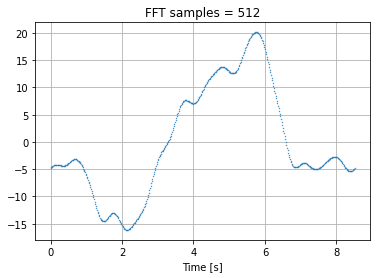

In [40]:
# make time stamp
t = np.linspace(1,nFFT,nFFT) * dt - dt
# print("Time list \n", t)

# make random signal
xt = pseudo_random(t, f0_=f0, p_ = p, powflag_ = ispow)

# plot
plt.figure()
plt.plot(t, xt, 'o', markersize=.4)
plt.title('FFT samples = ' + str(nFFT))
plt.xlabel('Time [s]')
plt.grid(True)
plt.show()

### 擬似ランダム信号の周波数スペクトラム


f0 = 0.1171875   nFFT = 512  dt = 0.016666666666666666


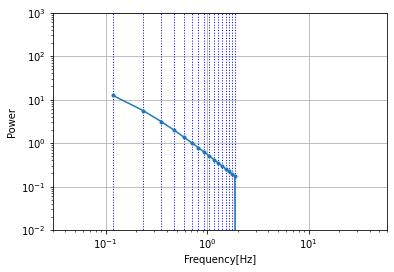

In [41]:
freq = np.fft.fftfreq(nFFT, dt)

fl = np.fft.fft(xt)/n2f 

# print (fs/nFFT) # 基底周波数を確認
# for f in freq:
#   print (f) # 設計した周波数は基底周波数の整数倍だから片対数グラフで等間隔にならなくてよい
# for F in fl:
#   print(F) # 設計した周波数成分のみにパワーが表れており，あとはe-15≒0
# plt.plot(freq,'o')# FFT後の周波数は整数倍

print('f0 =' , f0,'  nFFT =', nFFT, ' dt =', dt)

plt.figure()
plt.semilogx(freq[1:n2],  np.abs(fl[1:n2]), 'o-', markersize = 3)

for k in range(sidx, nFreq):
  if ispow:
    plt.vlines(fs/nFFT*np.power(p,k), 0, 1000, linestyle=':', linewidth=1, color='blue')
  else:
    plt.vlines(f0*(k), 0, 1000, linestyle=':', linewidth=1, color='blue')
plt.ylabel(r"Power")
plt.xlabel("Frequency[Hz]")
plt.xlim(0.03,60.0)
plt.ylim(0.01,1000)
plt.yscale('log')
plt.grid(True)
plt.show()

# print(np.abs(fl[1:n2]))

## 実験データのプロット関数

- 基底周波数 = FFT最低周波数(基底周波数 f0 = 60[Hz] / 1024[FFT samples] = 0.05859375 [Hz])


In [42]:
def plotFFT(n = nFFT):
    x = CSVdata["target_x"][15:15+n]
    y = CSVdata["cursor_x"][15:15+n]
    # print(np.size(x))
    plt.figure(figsize=(7, 6), facecolor = "white")

    freq = np.fft.fftfreq(nFFT, dt)
    X = np.fft.fft(x)/n2f

    plt.semilogx(freq[1:n2],  np.abs(X[1:n2]), 'o:', markersize = 3,label='target_x')

    Y = np.fft.fft(y)/n2f
    plt.semilogx(freq[1:n2],  np.abs(Y[1:n2]), 'o:', markersize = 3,label='cursor_x')

    for k in range(sidx, nFreq):
      if ispow:
        plt.vlines(fs/nFFT*np.power(p,k), 0, 1000, linestyle=':', linewidth=1, color='blue')
      else:
        plt.vlines(f0*k, 0, 1000, linestyle=':', linewidth=1, color='blue')
    plt.hlines(1,0.0001,1000)
    plt.ylabel(r"Amplitude")
    plt.xlabel("Frequency[Hz]")
    plt.legend()
    plt.title('FFT samples = ' + str(n))
    plt.xlim(0.03,10)
    plt.ylim(0.1,1000)
    plt.yscale('log')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    

# システム伝達関数
McRuerの閉ループ伝達関数であるT(f)=X(f)\*Y(f)/X(f)\*X(f)を求める。


以下のプロットでは、位相は進む成分を出力させないように、正の角度に対しては2πを減じている。


[1] https://tachilab.org/content/files/publication/review_papers/tachi1995IEEJ-02.pdf

/content/202005260011_f0_0.1171875_fs_60_trial_1_float.csv
read ok


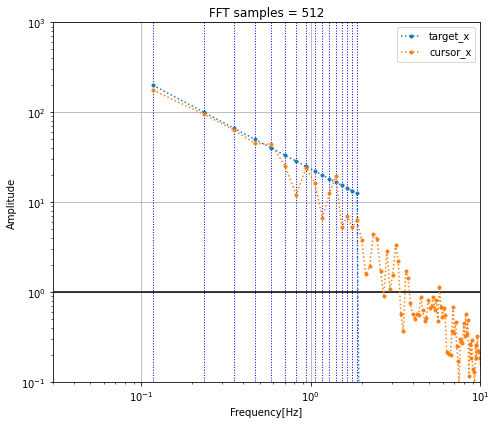

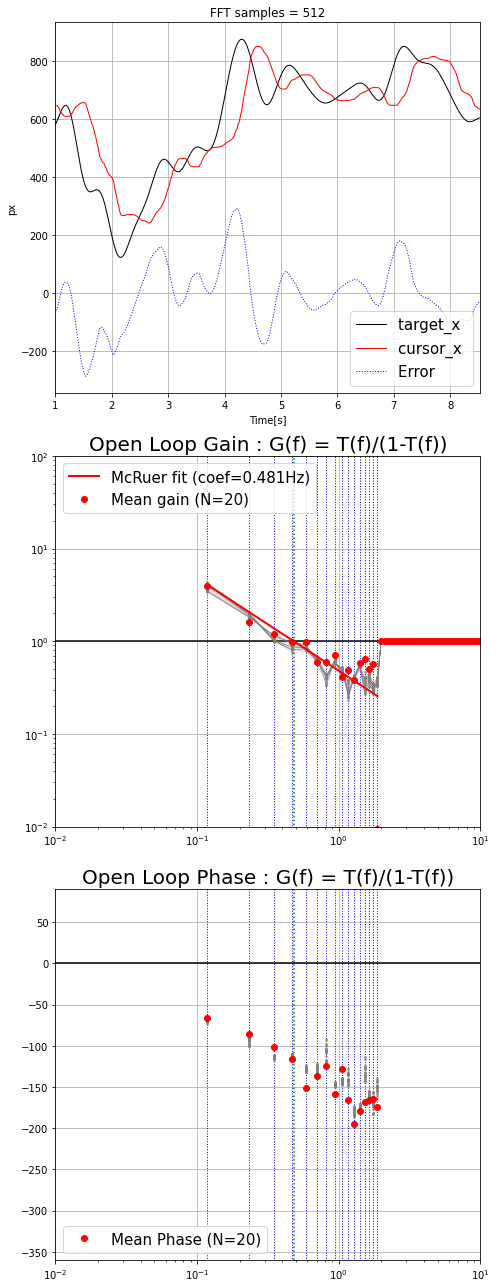

In [43]:
# coding: utf-8

import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Latest CSV File
list_of_files = glob.glob('/content/*.csv')
latest_file = max(list_of_files, key=os.path.getctime)
CSVdata = pd.read_csv(latest_file, header=0)

print(latest_file)
print("read ok")

plotFFT(nFFT) # 追加しました

# Num of Ensemble Mean
nE = 20
n = nFFT
XY_list = []
XX_list = []

Once = True

fig = plt.figure(figsize=(7, 18), facecolor = "white")
(ax1, ax2, ax3) = fig.subplots(3,1)

# fitting target function
# gradient : -1 (McRuer Supposition)
# target : section "b" of  "y = -x + b" 
def func(x, b):
    return (-x + b)

for s in range(nE):
    # st time stamp
    # st = int(s)*(int)((fs*60-nFFT)/nE) + 60
    st = s*10 + 1
    
    et = np.array(CSVdata["error_x"] [st:st+nFFT])
    xt = np.array(CSVdata["target_x"][st:st+nFFT]) 
    yt = np.array(CSVdata["cursor_x"][st:st+nFFT])
            
    if Once:
        ax1.plot(t, xt, lineWidth = 1.0, color='black', label='target_x ')
        ax1.plot(t, yt, lineWidth = 1.0, color='red' ,  label='cursor_x ')
        ax1.plot(t, et, lineWidth = 1.0, color='blue',  label='Error ' ,linestyle=':')  
        ax1.set_xlim(1, n*dt)
        ax1.set_title('FFT samples = ' + str(nFFT))
        ax1.set_xlabel("Time[s]")
        ax1.set_ylabel("px")
        ax1.legend(fontsize=15, loc='lower right')
        ax1.grid(True)

    # FFT 
    Xf = np.fft.fft(xt)/n2f
    Yf = np.fft.fft(yt)/n2f

    # 周波数応答 クロススペクトル xy /パワースペクトル xx
    XY = np.conj(Xf)*Yf # (cross spectrum)
    XX = np.conj(Xf)*Xf # (power spectrum)
    XY = Yf # (cross spectrum)
    XX = Xf # (power spectrum)

    # 伝達関数の導出    
    Tf = XY/XX   # (cross spectrum) / (power spectrum 閉ループ伝達関数
        
    # Aug 11, 2020
    # Masahiro Furukawa
    # 開ループ伝達関数であるG(f)を直接求まる閉ループ伝達関数T(f)から求めるように変更．
    # 導出式はG(f)=T(f)/(1-T(f))．これ以前の古川の版はすべて，閉ループ伝達関数T(f)に対してMcRuerモデルを当てはめているため誤り．
    # 参考文献：前田 太郎, 荒井 裕彦, 舘 暲: 頭部運動追従型両眼視覚提示装置の設計と評価, 日本ロボット学会誌, Vol.10, No.5, pp.99-109 (1992.9)
    # https://www.jstage.jst.go.jp/article/jrsj1983/10/5/10_5_655/_pdf/-char/ja
    Gf = Tf  / (1 - Tf)
    
    # アンサンブル平均用リスト
    XY_list.append(XY[0:n2])
    XX_list.append(XX[0:n2])
    # print(np.size(XY_list,0))
    
    # 個別プロット(Gain)
    ax2.loglog(freq[sidx:n2],  np.abs(Gf[sidx:n2]) , 'gray', alpha=0.5, marker='o',linewidth=0.5, markersize=2) 
    if Once:
        ax2.set_xlim(0.01, 10)
        ax2.set_ylim(0.01,100)        
        ax2.grid(True)
        for k in range(sidx,nFreq):
          if ispow:
            ax2.vlines(f0*np.power(p,k), 0, 1000, linestyle=':', linewidth=1,color='blue')
          else:
            ax2.vlines(f0*k,-500,500,linestyle=':',linewidth=1,color='blue')
            
                
    # 個別プロット(位相)
    ang = []
    for angle in np.angle(Gf[0:n2]):
        if (angle > 0.0):
            ang.append(angle - np.pi*2.0)
        else:
            ang.append(angle)
    ax3.semilogx(freq[sidx:nFreq], np.degrees(ang[sidx:nFreq]), 'gray', alpha=0.5, marker='o',linewidth=0, markersize=2)
    if Once:
        Once = False
        for k in range(sidx,nFreq):
          if ispow:
            ax3.vlines(f0*np.power(p,k), -360, 0, linestyle=':', linewidth=1,color='blue')
          else:
            ax3.vlines(f0*k,-500,500,linestyle=':',linewidth=1,color='blue')
        ax3.set_ylim(-360,90)
        ax3.set_xlim(0.01, 10)
        ax3.grid(True)

XY_mean = np.mean(XY_list, axis=0)  # アンサンブル平均
XX_mean = np.mean(XX_list, axis=0)  # アンサンブル平均
Tf = XY_mean / XX_mean       # アンサンブル平均された閉ループ伝達関数
# Aug 11, 2020
# Masahiro Furukawa
# 開ループ伝達関数であるG(f)を直接求まる閉ループ伝達関数T(f)から求めるように変更．
# 導出式はG(f)=T(f)/(1-T(f))．これ以前の古川の版はすべて，閉ループ伝達関数T(f)に対してMcRuerモデルを当てはめているため誤り．
# 参考文献：前田 太郎, 荒井 裕彦, 舘 暲: 頭部運動追従型両眼視覚提示装置の設計と評価, 日本ロボット学会誌, Vol.10, No.5, pp.99-109 (1992.9)
# https://www.jstage.jst.go.jp/article/jrsj1983/10/5/10_5_655/_pdf/-char/ja
Gf = Tf  / (1 - Tf)


log_abs = np.log10(np.abs(Gf[1:11]))
log_freq= np.log10(freq[1:11])

params, cov = curve_fit(func, log_freq, log_abs, p0=[0.0])  # liner fitting
fc = np.power(10.0,params[0])                               # cross over frequency
# McReur Fitting Line
ax2.loglog(freq[sidx:nFreq], 10**func(np.log10(freq[sidx:nFreq]), *params), c="r", label=("McRuer fit (coef={:.3f}Hz)").format(fc), lineWidth = 2.0)

# ゲインプロット(アンサンブル平均)
ax2.semilogx(freq[sidx:n2],  np.abs(Gf[sidx:n2]) , "red", marker='o', alpha=1.0, lineWidth = 0, label=("Mean gain (N={:d})").format(nE))

# 位相プロット(アンサンブル平均)
ang = []
for angle in  np.angle(Gf[0:nFreq]):
    if (angle > 0.0):
        ang.append(angle - np.pi*2.0)
    else:
        ang.append(angle)
ax3.semilogx(freq[sidx:nFreq], np.degrees(ang[sidx:nFreq]), 'red', marker='o', alpha=1.0, lineWidth = 0, label=("Mean Phase (N={:d})").format(nE)) 

ax2.vlines(fc, 0.0001,10000, linestyle=':', color='green')
ax3.vlines(fc, -360,100, linestyle=':', color='green')
ax2.hlines(1,0.0001,1000)
ax3.hlines(0,0.0001,1000)
ax2.legend(fontsize=15, loc='upper left')
ax3.legend(fontsize=15, loc='lower left')
# ax2.set_title("Gain : G(f) = T(f)/(1-T(f)), T(f)= E|X(f)*Y(f)| / E|X(f)*X(f)| ", fontsize=20)
ax2.set_title("Open Loop Gain : G(f) = T(f)/(1-T(f))", fontsize=20)
ax3.set_title("Open Loop Phase : G(f) = T(f)/(1-T(f))", fontsize=20)

plt.tight_layout()
plt.show()

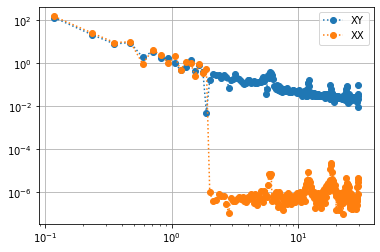

In [44]:
plt.loglog(freq[sidx:n2],np.abs(XY_mean[sidx:n2]),'o:', label='XY')
plt.grid(True)
plt.loglog(freq[sidx:n2],np.abs(XX_mean[sidx:n2]),'o:', label='XX')
plt.grid(True)
plt.legend()
plt.show()

In [45]:
# Masahiro Furukawa
# Aug 3, 2020
#

import numpy as np

# flip, add and subtract
def butterfly(x):
  X = np.zeros(len(x))

  X[0] = x[0] + x[1]
  X[1] = x[0] - x[1]
  return X

# my Bufferfly Calculator
# ref : https://www.onosokki.co.jp/HP-WK/eMM_back/emm140.pdf
def myFFT(x):
  X = []

  # pow detector
  # ref : https://kenyu-life.com/2019/01/15/n_ampersamd_n-1equal0/
  n = len(x)
  if (n&(n-1) != 0): 
    print(u"length of x does not equal pow number.")
    return []
  
  X = butterfly(x)

  return X

x = [10,11,12,13]
X = myFFT(x)

print('in ', x)
print('out', X)

print(bin(bin(3) and 0b01))

in  [10, 11, 12, 13]
out [21. -1.  0.  0.]
0b1


Aug 3, 2020
# 荒井裕彦先生流
フーリエ変換ののち，逆フーリエの結果で連続運動を作る．周波数成分が過不足なく再現することが保証される連続運動の作り方．